## Speed as Rhythm

### Background

Human and animal locomotion establishes a tight connection between movement in space and rhythm. For example, [Laffi et al., 2024](https://nyaspubs.onlinelibrary.wiley.com/doi/full/10.1111/nyas.15271) quantified the rhythmic differences in the temporal structure of horses' walk, trot, and canter, and promised to better explore the connection between rhythmic regularity and locomotor speed. In human-computer interaction, it has been previously shown how it is possible to control the trajectories of objects in the two-dimensional space by producing rhythmic cells [Rocchesso et al., 2024](https://www.sciencedirect.com/science/article/pii/S1071581924001411), each cell being formed by duplets or triplets of pulses, whose Inter-Onset-Interval (IOI) is inversely proportional to one of the two orthogonal components of velocity. The movement of an object in space can be monitored just by rhythm [Rocchesso et al., 2024](https://www.sciencedirect.com/science/article/pii/S1071581924001411), or by a combination of rhythm, pitch, and spatialization [Bellino et al., 2024](https://dl.acm.org/doi/abs/10.1145/3678299.3678340). 

In data sonification, pitch and rhythm (or IOI) of sounds can be equally effective for auditorilly graphing time-series data [Guiotto et al., 2024](https://iopscience.iop.org/article/10.3847/1538-3881/ad2943/meta), and rhytm perception can also effectively occur in haptics [Bernard et al., 2022](https://www.nature.com/articles/s41598-022-08152-w). 

With audition, there are opportunities and limits of the use of rhythm for the perception and control of trajectories in space. Namely, humans can segregate concurrent auditory streams [Hermes, 2023](https://link.springer.com/content/pdf/10.1007/978-3-031-25566-3.pdf), and detect and reproduce IOIs and their ratios [Nave et al., 2023](https://www.sciencedirect.com/science/article/pii/S0010027723002688?via%3Dihub). 

Relative just noticeable differences (JNDs) in tempo average from 6\% for single-interval sequences, to about 2\% for multiple-interval sequences [Miller and McAuley, 2005](https://link.springer.com/content/pdf/10.3758/BF03193548.pdf).

It has been shown that the production of rhythmic cells by means of two buttons is suitable for controlling trajectories in space [Rocchesso et al., 2024](https://www.sciencedirect.com/science/article/pii/S1071581924001411), but the role of auditory feedback in filling blanks of visual information, as trajectories could be imagined as well as deduced from rhythm. In the proposed experiments, we address the specific question of how accurate the perception and production of speed and direction are. 


### Objectives

1. Showing that humans can interpret two overlapping rhythms and reproduce the direction and speed of a moving object, when each of the two rhythms is made to correspond to one of the components of the velocity vector;
2. Showing that it is possible to produce two overlapping rhythms that correspond to a visually perceived linear motion trajectory;
3. Measuring the accuracy and precision of perception and action of rhythmic trajectories, by two tasks of multisensory translation between perception and action.

In [112]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import glob
import scipy.stats as stats

from scipy.stats import normaltest
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.descriptivestats import sign_test
from scipy.stats import shapiro
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import boxcox
from scipy.stats import yeojohnson
from scipy.stats import wilcoxon
from scipy.stats import iqr


sns.set(style="darkgrid")


In [57]:
def categorize_angles_into_quadrants(df, angle_column='angle_degrees', quadrant_column='quadrant'):
    """
    Transforms angles in degrees into quadrants (I, II, III, IV) and adds a 
    new column with the quadrant information to the DataFrame.

    Args:
        df: Pandas DataFrame containing an angle column.
        angle_column: Name of the column containing angles in degrees.  Defaults to 'angle_degrees'.
        quadrant_column: Name of the new column to store quadrant information. Defaults to 'quadrant'.

    Returns:
        Pandas DataFrame with the added quadrant column.  Returns the original DataFrame if the angle column is not found.
        Prints an error message if the angle column is not found.
    """

    if angle_column not in df.columns:
        print(f"Error: Angle column '{angle_column}' not found in DataFrame.")
        return df

    df[quadrant_column] = np.nan  # Initialize with NaN (for consistency with NaN angles)

    # Handle NaN angles directly
    nan_mask = df[angle_column].isna()

    # Vectorized operations for non-NaN angles
    valid_mask = ~nan_mask  # Invert the NaN mask

    angles = df.loc[valid_mask, angle_column].astype(float) % 360  # Vectorized modulo

    df.loc[valid_mask & (angles < 90), quadrant_column] = 'I'
    df.loc[valid_mask & (angles >= 90) & (angles < 180), quadrant_column] = 'II'
    df.loc[valid_mask & (angles >= 180) & (angles < 270), quadrant_column] = 'III'
    df.loc[valid_mask & (angles >= 270), quadrant_column] = 'IV'


    return df

In [58]:
def detect_flips(df, quadrant1_col, quadrant2_col, flip_col='flip_type'):
    """
    Detects horizontal, vertical, and double flips based on quadrant changes.

    Args:
        df: Pandas DataFrame containing two quadrant columns.
        quadrant1_col: Name of the first quadrant column.
        quadrant2_col: Name of the second quadrant column.
        flip_col: Name of the new column to store flip information. Defaults to 'flip_type'.

    Returns:
        Pandas DataFrame with the added flip_type column.  Returns original DataFrame if columns are not found.
        Prints error messages if columns are not found.
    """
    
    if quadrant1_col not in df.columns:
        print(f"Error: Quadrant column '{quadrant1_col}' not found in DataFrame.")
        return df

    if quadrant2_col not in df.columns:
        print(f"Error: Quadrant column '{quadrant2_col}' not found in DataFrame.")
        return df

    df[flip_col] = 'N'  # Initialize

    # Create boolean masks for each flip type (vectorized)
    h_mask = ((df[quadrant1_col] == 'I') & (df[quadrant2_col] == 'II')) | \
             ((df[quadrant1_col] == 'II') & (df[quadrant2_col] == 'I')) | \
             ((df[quadrant1_col] == 'III') & (df[quadrant2_col] == 'IV')) | \
             ((df[quadrant1_col] == 'IV') & (df[quadrant2_col] == 'III'))

    v_mask = ((df[quadrant1_col] == 'I') & (df[quadrant2_col] == 'IV')) | \
             ((df[quadrant1_col] == 'IV') & (df[quadrant2_col] == 'I')) | \
             ((df[quadrant1_col] == 'II') & (df[quadrant2_col] == 'III')) | \
             ((df[quadrant1_col] == 'III') & (df[quadrant2_col] == 'II'))

    b_mask = ((df[quadrant1_col] == 'I') & (df[quadrant2_col] == 'III')) | \
             ((df[quadrant1_col] == 'III') & (df[quadrant2_col] == 'I')) | \
             ((df[quadrant1_col] == 'II') & (df[quadrant2_col] == 'IV')) | \
             ((df[quadrant1_col] == 'IV') & (df[quadrant2_col] == 'II'))

    same_mask = df[quadrant1_col] == df[quadrant2_col]

    nan_mask = df[quadrant1_col].isna() | df[quadrant2_col].isna()

    # Apply masks (vectorized)
    df.loc[h_mask, flip_col] = 'H'
    df.loc[v_mask, flip_col] = 'V'
    df.loc[b_mask, flip_col] = 'B'
    df.loc[same_mask, flip_col] = 'N' # No flip if same
    df.loc[nan_mask, flip_col] = np.nan # NaN if any is NaN

    return df

# Task a
Read all participants' data for task **a**. Add a column with participant number.
In Task a, stimulus is sound (rhythm) and response is movement (dragging).

In [59]:
df = pd.DataFrame()
NPart = 0
for f in glob.glob('./SpeedAsRhythm/Partecipante??_a*.csv'):
    part = pd.read_csv(f)
    npart = int(f[28:30])
    part['nPart'] = npart
    NPart+=1
    df = pd.concat([df, part])
df = df.sort_values(by='nPart', ascending=True)
df.tail()
print(len(df))
print("number of participants = %3d" % NPart)

800
number of participants =  20


In [60]:
# rename the columns
df.columns = ['trial', 'soundSpeed', 'soundAngle', 'movSpeed', 'movAngle', 'soundStart', 'startDragTime', 'endDragTime', 'hInterval', 'vInterval', 'nPart']

In [61]:
# determine quadrant for sound (stimulus) and for movement (response)
categorize_angles_into_quadrants(df, angle_column='soundAngle', quadrant_column='soundQuadrant');
categorize_angles_into_quadrants(df, angle_column='movAngle', quadrant_column='movQuadrant');
detect_flips(df, 'soundQuadrant', 'movQuadrant', 'flip')
# add differences between stimulus and response (stimulus - response)
# add speed_diff and angle_diff if soundQuadrand and movQuadrant are equal (else, NaN)
df['speed_diff'] = np.where(df['flip'] == 'N', df['soundSpeed'] - df['movSpeed'], np.nan)
df['angle_diff'] = np.where(df['flip'] == 'N', df['soundAngle'] - df['movAngle'], np.nan)
display(df)
dfExpA=df

,trial,soundSpeed,soundAngle,movSpeed,movAngle,soundStart,startDragTime,endDragTime,hInterval,vInterval,nPart,soundQuadrant,movQuadrant,flip,speed_diff,angle_diff
19,19,37.684478,304.816029,15.552421,335.947471,1740393556366,1740393576186,1740393588649,1394.330718,969.663711,1,IV,IV,N,22.132057,-31.131442
24,24,28.267477,317.873231,27.334524,319.398705,1740393650899,1740393658815,1740393665898,1430.961216,1582.189494,1,IV,IV,N,0.932953,-1.525474
25,25,33.835866,126.027625,41.138586,168.690068,1740393670399,1740393680921,1740393685631,1507.430202,1096.322995,1,II,II,N,-7.302720,-42.662443
26,26,72.207546,143.044079,60.287944,142.774601,1740393690131,1740393694073,1740393697281,519.922342,691.065773,1,II,II,N,11.919603,0.269479
27,27,30.696642,218.376044,52.092136,230.460213,1740393701782,1740393706405,1740393710114,1246.637830,1574.217141,1,III,III,N,-21.395493,-12.084168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,15,69.507615,139.441469,80.513627,157.813322,1741191824491,1741191831856,1741191834257,568.097221,663.782094,20,II,II,N,-11.006012,-18.371853
16,16,76.032558,302.148626,89.727006,288.248924,1741191838758,1741191845085,1741191847256,741.505288,466.022798,20,IV,IV,N,-13.694449,13.899702
17,17,94.537060,77.109272,83.255622,81.164627,1741191851758,1741191854994,1741191857340,1422.441589,325.540360,20,I,I,N,11.281438,-4.055355
10,10,103.614743,282.027661,186.233377,274.596808,1741191766591,1741191769201,1741191770273,1389.426473,296.032861,20,IV,IV,N,-82.618633,7.430853


Show number and kind of flips per participant

Compute average number of flips per participant, of the different kinds. 


In [62]:
errors_df = df.groupby(['nPart', 'flip']).size().reset_index(name='Count')

# Create a pivot table to fill missing values with 0
pivot_table = errors_df.pivot_table(values='Count', index='nPart', columns='flip', aggfunc='sum', fill_value=0)

sum = pivot_table.sum()
print("sum = ")
print(sum)

means = pivot_table.mean()
print("means = ")
print(means)

stds = pivot_table.std()
print("std = ")
print(stds)


sum = 
flip
B      2
H      4
N    762
V     32
dtype: int64
means = 
flip
B     0.1
H     0.2
N    38.1
V     1.6
dtype: float64
std = 
flip
B    0.307794
H    0.523148
N    1.447321
V    1.231174
dtype: float64


In [63]:
dfN = df.loc[df['flip'] == 'N']
print("number of flips = %2d" % (len(df) - len(dfN)))

number of flips = 38


### Histograms of generated speed and angle. 

TBD: Explain the shapes of the distributions, based on uniform generation of inter-onset intervals along the two axes. 

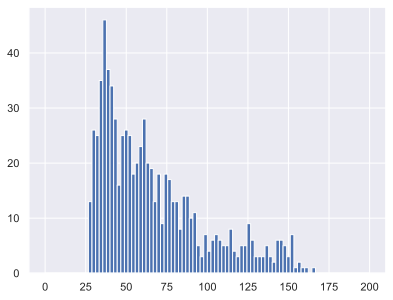

In [64]:
plt.hist(dfN.soundSpeed, bins=90, range = (0, 200));

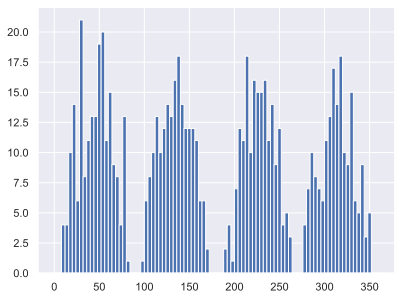

In [65]:
plt.hist(dfN.soundAngle,bins=90, range=(0,360));

### Statistics of angle and speed error

- Normality test
- skewness and kurtosis
- significance of difference of the means from zero (parametric or non-parametric depending on normality)


In [66]:
errAngle = dfN.movAngle - dfN.soundAngle
print(np.mean(errAngle))
print(np.std(errAngle))
print(np.quantile(errAngle, [0,0.25,0.5,0.75,1]))
print(iqr(errAngle))
# print(errAngle.to_string())

-0.12010458436610644
13.003019172861446
[-47.64144663  -7.63950513  -0.1527576    7.59683043  60.88307738]
15.23633555234997


D'Agostino statistics=32.311, p=0.000
Shapiro-Wilk statistics=0.982, p=0.000
skewness=0.065
kurtosis=1.681


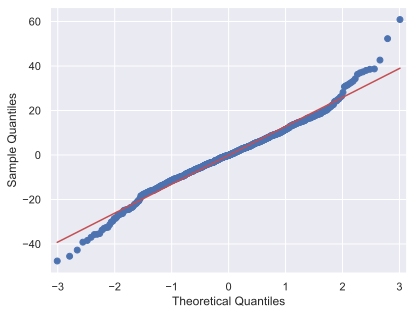

In [67]:
qqplot(errAngle, line='s')
# D'Agostino normality test
stat,p = normaltest(errAngle) 
print('D\'Agostino statistics=%.3f, p=%.3f' % (stat, p))
# Shapiro-Wilk normality test
stat, p = shapiro(errAngle) 
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))

print('skewness=%.3f' % skew(errAngle))
print('kurtosis=%.3f' % kurtosis(errAngle))

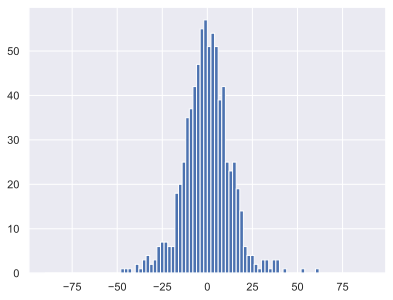

In [68]:
plt.hist(errAngle, bins=90, range = (-90,90));

Ok, the distribution is not normal (fat tails). We can try to trim and distort the distribution to achieve Normality. The following methods have been tried, with no success.

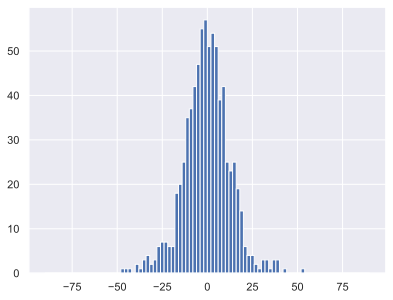

In [69]:
# Data Transformation aiming at normality

# trim values to be smaller than 60 degrees
tanErrAngle = errAngle[errAngle<60]

# tanErrAngle = (np.sin(errAngle/180*np.pi)) 
# tanErrAngle = np.tan(errAngle/180*np.pi)
# tanErrAngle = boxcox(errAngle+90, 0.5)
# tanErrAngle,lam = boxcox(errAngle+90)
# tanErrAngle, lam = yeojohnson(errAngle)

# ----
# data_np = np.array(errAngle)

# 1. Standardization
# mean = np.mean(data_np)
# std = np.std(data_np)
# standardized_data = (data_np - mean) / std

# 2. Square of absolute values
# abs_sqrt_data = (np.abs(standardized_data))**2

# 3. Restore original signs
# tanErrAngle = np.sign(standardized_data) * abs_sqrt_data
# ----

# print(lam)

plt.hist(tanErrAngle, bins=90, range = (-90,90));

D'Agostino statistics=23.158, p=0.000
Shapiro-Wilk statistics=0.986, p=0.000
skewness=-0.055
kurtosis=1.283


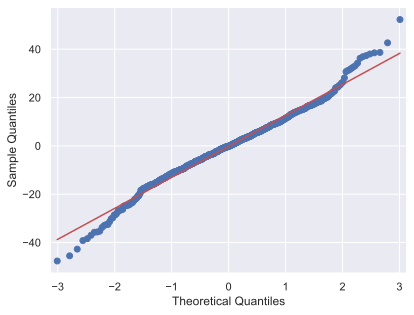

In [70]:
qqplot(tanErrAngle, line='s')
# D'Agostino normality test
stat,p = normaltest(tanErrAngle) 
print('D\'Agostino statistics=%.3f, p=%.3f' % (stat, p))
# Shapiro-Wilk normality test
stat, p = shapiro(tanErrAngle) 
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))

print('skewness=%.3f' % skew(tanErrAngle))
print('kurtosis=%.3f' % kurtosis(tanErrAngle))

In [71]:
# (nonparametric) sign test to see if the median is significantly different from zero
stat, p = sign_test(errAngle, 0)
print(stat, p)

# Wilcoxon signed rank test
hypMedian = 0.0
rank, p = wilcoxon(errAngle - hypMedian, zero_method='wilcox', correction=False)
print(rank, p)


-5.0 0.7444215806515366
144246.0 0.855675340604174


So, we can not reject the null hypothesis that the median is zero. Although the distribution is not normal, skewness is small, thus indicating a symmetric distribution. 
Precision can be given by the interquartile range, i.e. $15.236$. This can be interpreted as the differential threshold, or just noticeable difference, in angle.

In [72]:
errSpeed = dfN.soundSpeed - dfN.movSpeed
print(np.mean(errSpeed))
print(np.std(errSpeed))
print(np.quantile(errSpeed, [0,0.25,0.5,0.75,1]))
print(iqr(errSpeed))

-12.955674264514284
39.36857503629376
[-471.13854769  -25.1275922    -9.98518953    5.23863187   93.12248043]
30.36622407083801


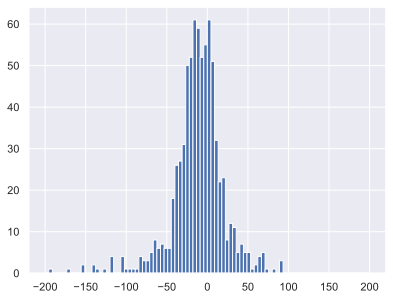

In [73]:
plt.hist(errSpeed, bins=90, range=(-200, 200));

D'Agostino statistics=641.643, p=0.000
Shapiro-Wilk statistics=0.776, p=0.000
skewness=-3.448
kurtosis=30.197


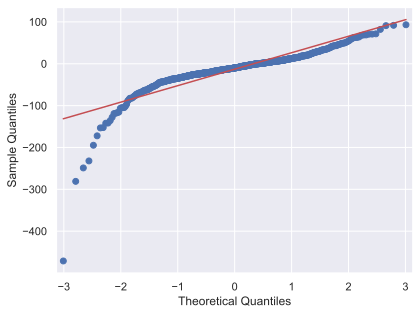

In [74]:
qqplot(errSpeed, line='s')
# D'Agostino normality test
stat,p = normaltest(errSpeed) 
print('D\'Agostino statistics=%.3f, p=%.3f' % (stat, p))
# Shapiro-Wilk normality test
stat, p = shapiro(errSpeed) 
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))

print('skewness=%.3f' % skew(errSpeed))
print('kurtosis=%.3f' % kurtosis(errSpeed))

In [75]:
# (nonparametric) sign test to see if the median is significantly different from zero
stat, p = sign_test(errSpeed, 0)
print(stat, p)

# Wilcoxon signed rank test
hypMedian = 0.0
rank, p = wilcoxon(errSpeed - hypMedian, zero_method='wilcox', correction=False)
print(rank, p)


-122.0 6.719491295808916e-19
81647.0 1.0566584945891953e-25


We can definitely reject the null hypothesis that the median is zero. The skewness is quite large, and kurtosis is large as well. The median ($-9.985$) can give a measure of accuracy. Precision, on the other hand, can be given by the interquartile range, i.e. $30.366$. This can be interpreted as the differential threshold, or just noticeable difference, in speed.

Do participant think longer when they have smaller errors? Apparently not.

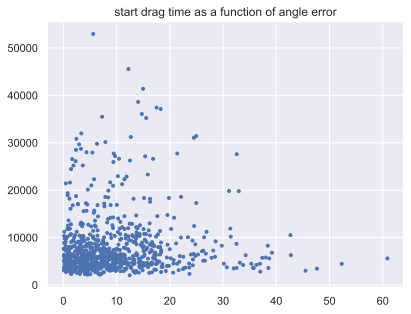

In [76]:
fig, ax = plt.subplots()
ax.plot(abs(errAngle), abs(dfN.startDragTime-dfN.soundStart), '.')
ax.set_title('start drag time as a function of angle error');

# Task b
Read all participants' data for task **b**. Add a column with participant number.

In [77]:
df = pd.DataFrame()
NPart = 0
for f in glob.glob('./SpeedAsRhythm/Partecipante??_b*.csv'):
    part = pd.read_csv(f)
    npart = int(f[28:30])
    part['nPart'] = npart
    NPart+=1
    df = pd.concat([df, part])
df = df.sort_values(by='nPart', ascending=True)
df.tail()
print(len(df))
print("number of participants = %3d" % NPart)

800
number of participants =  20


In [78]:
# rename the columns
df.columns = ['trial', 'movSpeed', 'movAngle', 'tapSpeed', 'tapAngle', 'movStart', 'tapHor', 'tapVer', 'tapHor2', 'tapVer2', 'hInterval', 'vInterval', 'nPart']

In [79]:
# determine quadrant for sound (stimulus) and for movement (response)
categorize_angles_into_quadrants(df, angle_column='movAngle', quadrant_column='movQuadrant');
categorize_angles_into_quadrants(df, angle_column='tapAngle', quadrant_column='tapQuadrant');
detect_flips(df, 'movQuadrant', 'tapQuadrant', 'flip')
# add differences between stimulus and response (stimulus - response)
# add speed_diff and angle_diff if soundQuadrand and movQuadrant are equal (else, NaN)
df['speed_diff'] = np.where(df['flip'] == 'N',  df['movSpeed'] - df['tapSpeed'], np.nan)
df['angle_diff'] = np.where(df['flip'] == 'N',  df['movAngle'] - df['tapAngle'], np.nan)
display(df)
dfExpB=df

,trial,movSpeed,movAngle,tapSpeed,tapAngle,movStart,tapHor,tapVer,tapHor2,tapVer2,hInterval,vInterval,nPart,movQuadrant,tapQuadrant,flip,speed_diff,angle_diff
38,38,29.069538,139.792341,18.510638,148.937093,1740394576071,1740394590426,1740394584867,1740394592318,1740394588008,1351.309406,1598.625247,1,II,II,N,10.558899,-9.144751
15,15,47.295864,154.388125,30.871862,127.869972,1740394327691,1740394330588,1740394334477,1740394332171,1740394335708,703.421001,1467.372329,1,II,II,N,16.424002,26.518153
14,14,31.558088,134.454512,36.150549,133.707467,1740394315892,1740394322676,1740394319730,1740394323877,1740394320878,1357.375186,1331.772242,1,II,II,N,-4.592461,0.747046
13,13,77.480473,342.555969,67.151947,340.139432,1740394306524,1740394308565,1740394310764,1740394309040,1740394312079,405.859724,1291.620691,1,IV,IV,N,10.328526,2.416537
12,12,32.529874,42.008159,26.163425,44.258234,1740394295225,1740394301120,1740394298062,1740394302721,1740394299705,1241.140979,1378.032018,1,I,I,N,6.366448,-2.250075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,14,138.820469,65.656067,109.941678,53.150256,1741191186673,1741191194739,1741191191888,1741191195194,1741191192229,524.259097,237.196171,20,I,I,N,28.878791,12.505811
15,15,74.018834,158.122704,51.863848,157.301473,1741191199007,1741191205837,1741191202797,1741191206464,1741191204296,436.755652,1087.709087,20,II,II,N,22.154986,0.821231
16,16,53.399478,317.429087,44.009027,336.737338,1741191210273,1741191218437,1741191214920,1741191219179,1741191216646,762.862920,830.452958,20,IV,IV,N,9.390451,-19.308251
9,9,92.749237,200.641512,36.119262,148.705422,1741191122743,1741191133175,1741191130539,1741191134147,1741191132138,345.641464,917.545167,20,III,II,V,NaN,NaN


Show number and kind of flips per participant

Compute average number of flips per participant, of the different kinds. 

TBD: test for significance of the difference in total number of flips in the two tasks A and B

In [80]:
errors_df = df.groupby(['nPart', 'flip']).size().reset_index(name='Count')

# Create a pivot table to fill missing values with 0
pivot_table = errors_df.pivot_table(values='Count', index='nPart', columns='flip', aggfunc='sum', fill_value=0)

sum = pivot_table.sum()
print("sum = ")
print(sum)

means = pivot_table.mean()
print("means = ")
print(means)

stds = pivot_table.std()
print("std = ")
print(stds)


sum = 
flip
H      2
N    790
V      8
dtype: int64
means = 
flip
H     0.1
N    39.5
V     0.4
dtype: float64
std = 
flip
H    0.307794
N    0.827170
V    0.680557
dtype: float64


In [81]:
dfN = df.loc[df['flip'] == 'N']
print("number of flips = %2d" % (len(df) - len(dfN)))

number of flips = 10


### Histograms of generated speed and angle.

TBD Explain the shapes of the distributions, based on uniform generation of inter-onset intervals along the two axes.


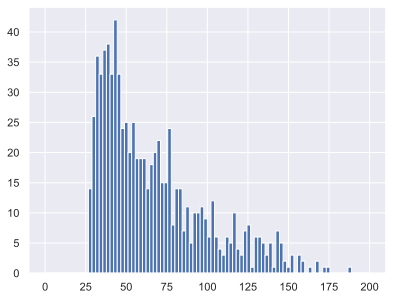

In [82]:
plt.hist(df.movSpeed, bins=90, range=(0, 200));

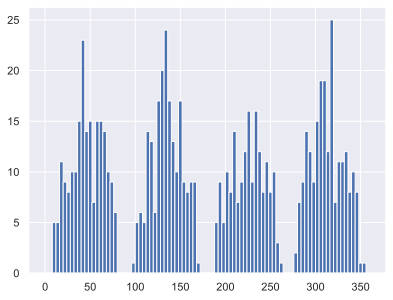

In [83]:
plt.hist(dfN.movAngle,bins=90, range=(0,360));

### Statistics of angle and speed error

- Normality test
- skewness and kurtosis
- Significance of difference of the means from zero (parametric or non-parametric depending on normality)


In [84]:
errAngle = dfN.tapAngle - dfN.movAngle
print(np.mean(errAngle))
print(np.std(errAngle))
print(np.quantile(errAngle, [0,0.25,0.5,0.75,1]))
print(iqr(errAngle))
# print(errAngle.to_string())

0.16464207238111606
12.573791197290275
[-43.07214903  -7.61908786   0.0687017    7.47624921  54.57127197]
15.095337066988169


D'Agostino statistics=52.710, p=0.000
Shapiro-Wilk statistics=0.979, p=0.000
skewness=0.367
kurtosis=1.810


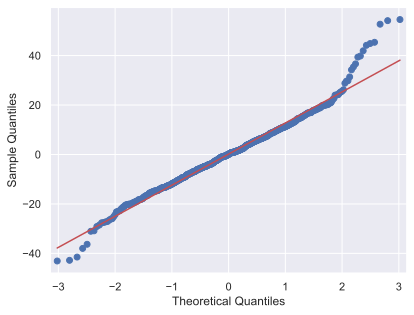

In [85]:
qqplot(errAngle, line='s')
# D'Agostino normality test
stat,p = normaltest(errAngle) 
print('D\'Agostino statistics=%.3f, p=%.3f' % (stat, p))
# Shapiro-Wilk normality test
stat, p = shapiro(errAngle) 
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))

print('skewness=%.3f' % skew(errAngle))
print('kurtosis=%.3f' % kurtosis(errAngle))

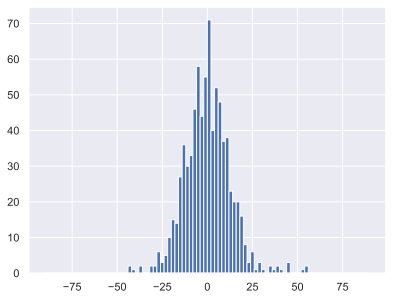

In [86]:
plt.hist(errAngle, bins=90, range=(-90,90));

In [87]:
# (nonparametric) sign test to see if the median is significantly different from zero
stat, p = sign_test(errAngle, 0)
print(stat, p)

# Wilcoxon signed rank test
hypMedian = 0.0
rank, p = wilcoxon(errAngle - hypMedian, zero_method='wilcox', correction=False)
print(rank, p)

4.0 0.8033421130139473
155829.0 0.9510953116282331


So, we can not reject the null hypothesis that the median is zero. Although the distribution is not normal, skewness is relatively small, thus indicating a symmetric distribution. Precision can be given by the interquartile range, i.e. $15.095$. This can be interpreted as the differential threshold, or just noticeable difference, in angle.

13.033248729090545
26.16883952364156
[-78.43793091  -0.66687841  10.04097559  25.10869426 114.90742663]
25.775572672886387


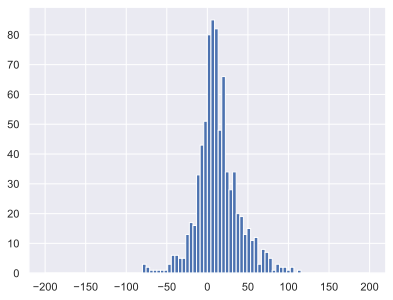

In [88]:
errSpeed = dfN.movSpeed - dfN.tapSpeed
print(np.mean(errSpeed))
print(np.std(errSpeed))
print(np.quantile(errSpeed, [0,0.25,0.5,0.75,1]))
print(iqr(errSpeed))
plt.hist(errSpeed, bins=90, range=(-200,200));

D'Agostino statistics=45.946, p=0.000
Shapiro-Wilk statistics=0.966, p=0.000
skewness=0.322
kurtosis=1.676


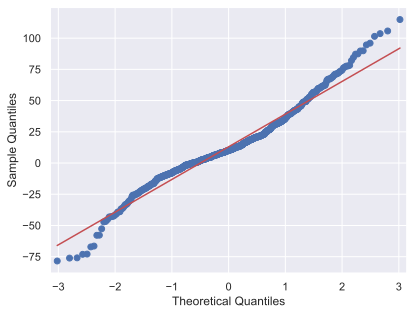

In [89]:
qqplot(errSpeed, line='s')
# D'Agostino normality test
stat,p = normaltest(errSpeed) 
print('D\'Agostino statistics=%.3f, p=%.3f' % (stat, p))
# Shapiro-Wilk normality test
stat, p = shapiro(errSpeed) 
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))

print('skewness=%.3f' % skew(errSpeed))
print('kurtosis=%.3f' % kurtosis(errSpeed))

In [90]:
# (nonparametric) sign test to see if the median is significantly different from zero
stat, p = sign_test(errSpeed, 0)
print(stat, p)

# Wilcoxon signed rank test
hypMedian = 0.0
rank, p = wilcoxon(errSpeed - hypMedian, zero_method='wilcox', correction=False)
print(rank, p)


187.0 9.315455466944132e-42
67069.0 6.738704523206971e-44


We can definitely reject the null hypothesis that the median is zero. The skewness is relatively small, and kurtosis is quite large. The median (-10.041) can give a measure of accuracy. Precision, on the other hand, can be given by the interquartile range, i.e. $25.776$. This can be interpreted as the differential threshold, or just noticeable difference, in speed.

Do participant think longer when they have smaller errors? Apparently not.

Text(0.5, 1.0, 'start tapping time as a function of angle error')

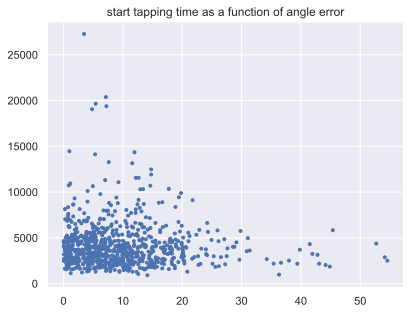

In [91]:
fig, ax = plt.subplots()
ax.plot(abs(errAngle), abs(dfN[['tapHor','tapVer']].min(axis=1) - dfN.movStart ), '.')
ax.set_title('start tapping time as a function of angle error')

# Comparison of angle between Task a and Task b

Duplicate labels found in the index. Resetting the index.


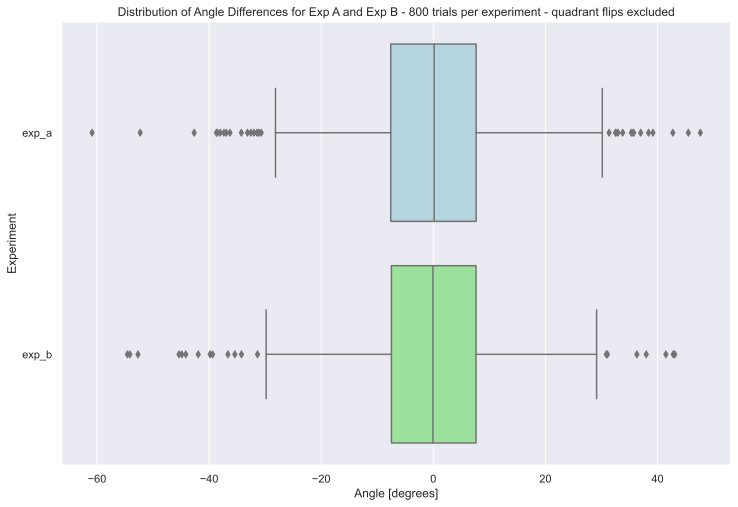

In [134]:
dfExpA = dfExpA.reset_index(drop=True)
dfExpB = dfExpB.reset_index(drop=True)

# add a column to identify the experiment
dfExpA['experiment'] = 'exp_a'
dfExpB['experiment'] = 'exp_b'

# concatenate the two dataframes
combined_df = pd.concat([dfExpA, dfExpB])

# control if any labels are duplicated in the index
if combined_df.index.duplicated().any():
    print("Duplicate labels found in the index. Resetting the index.")
    combined_df = combined_df.reset_index(drop=True)
    
# create a horizontal boxplot for 'angle_diff', color identifies the task
plt.figure(figsize=(12, 8))
sns.boxplot(x='angle_diff', y='experiment', data=combined_df, orient='h', palette={'exp_a': 'lightblue', 'exp_b': 'lightgreen'})

# set labels and title
plt.xlabel('Angle [degrees]')
plt.ylabel('Experiment')
plt.title('Distribution of Angle Differences for Exp A and Exp B - 800 trials per experiment - quadrant flips excluded')

plt.savefig('angle-a-vs-b.pdf', format='pdf')
plt.show()

## Angle difference per participant

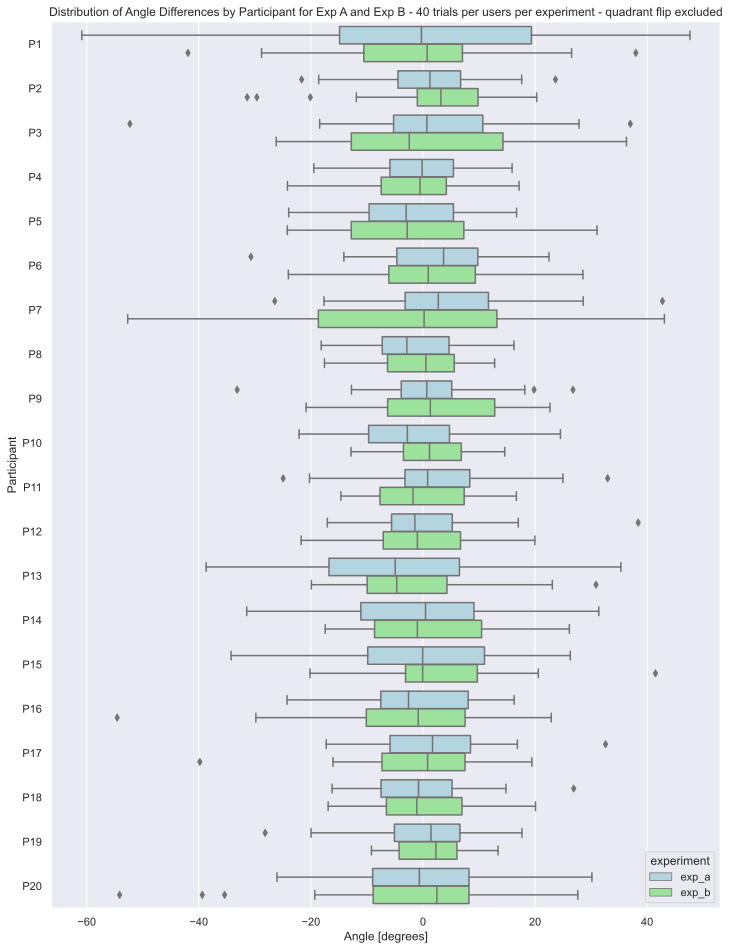

In [135]:
# create a horizontal boxplot for for each participant, alternating between the two tasks
plt.figure(figsize=(12, 16))
sns.boxplot(x='angle_diff', y='nPart', hue='experiment', data=combined_df, orient='h', palette={'exp_a': 'lightblue', 'exp_b': 'lightgreen'})

# set labels and title
plt.xlabel('Angle [degrees]')
plt.ylabel('Participant')
plt.title('Distribution of Angle Differences by Participant for Exp A and Exp B - 40 trials per users per experiment - quadrant flip excluded')

# modify the y axis labels to show P1, P2, ..., P20
participant_labels = [f'P{i}' for i in range(1, 21)]
plt.yticks(ticks=range(20), labels=participant_labels)

plt.savefig('angle-a-vs-b-users.pdf', format='pdf')
plt.show()

### Median and quartiles of angle per participant

In [103]:
quartiles_diffs_angle = pd.DataFrame()

# compute Q1, median, Q3, of angles per participant per task
for exp in ['exp_a', 'exp_b']:
    mask = combined_df['experiment'] == exp

    first_quartile = combined_df[mask].groupby('nPart')['angle_diff'].quantile(0.25).reset_index()
    first_quartile.columns = ['nPart', f'angle_diff_q1_{exp}']

    median_diff = combined_df[mask].groupby('nPart')['angle_diff'].median().reset_index()
    median_diff.columns = ['nPart', f'angle_diff_median_{exp}']

    third_quartile = combined_df[mask].groupby('nPart')['angle_diff'].quantile(0.75).reset_index()
    third_quartile.columns = ['nPart', f'angle_diff_q3_{exp}']

    if quartiles_diffs_angle.empty:
        quartiles_diffs_angle = first_quartile
    else:
        quartiles_diffs_angle = pd.merge(quartiles_diffs_angle, first_quartile, on='nPart', how='outer')

    quartiles_diffs_angle = pd.merge(quartiles_diffs_angle, median_diff, on='nPart', how='outer')
    quartiles_diffs_angle = pd.merge(quartiles_diffs_angle, third_quartile, on='nPart', how='outer')

display(quartiles_diffs_angle)

,nPart,angle_diff_q1_exp_a,angle_diff_median_exp_a,angle_diff_q3_exp_a,angle_diff_q1_exp_b,angle_diff_median_exp_b,angle_diff_q3_exp_b
0,1,-14.886824,-0.279188,19.355183,-10.557408,0.747046,7.044627
1,2,-4.463466,1.247048,6.715283,-1.011754,3.192283,9.820739
2,3,-5.248292,0.690879,10.681444,-12.787343,-2.443127,14.273522
3,4,-5.904252,-0.152367,5.430430,-7.457312,-0.532872,4.166486
4,5,-9.611642,-3.003657,5.439202,-12.799867,-2.817485,7.290764
5,6,-4.666703,3.673634,9.785447,-6.092914,0.939359,9.341673
6,7,-3.179077,2.736214,11.681950,-18.670114,0.198780,13.192254
7,8,-7.266963,-2.879141,4.647668,-6.330138,0.522222,5.585941
8,9,-3.878057,0.682268,5.131046,-6.309681,1.309593,12.798027
9,10,-9.701946,-2.785576,4.725103,-3.486927,1.165224,6.839369


Check if quartile and median distributions are normal

Shapiro-Wilk statistics=0.975, p=0.854


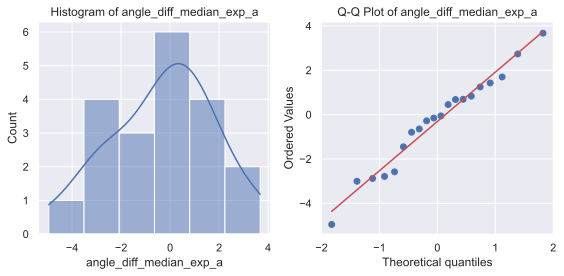

Shapiro-Wilk statistics=0.978, p=0.912


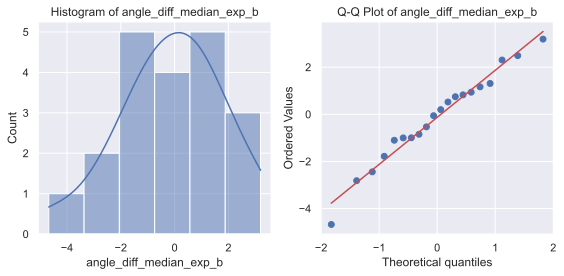

Shapiro-Wilk statistics=0.898, p=0.039


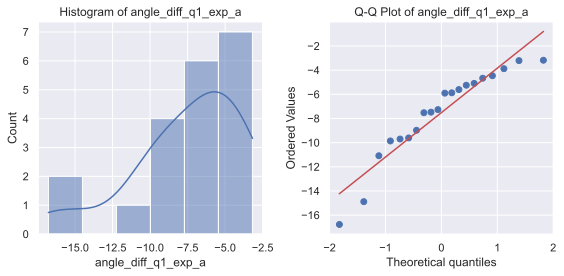

Shapiro-Wilk statistics=0.950, p=0.362


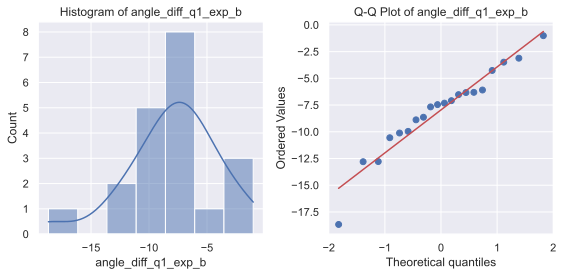

Shapiro-Wilk statistics=0.814, p=0.001


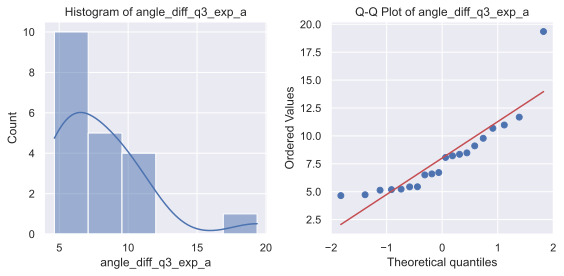

Shapiro-Wilk statistics=0.926, p=0.131


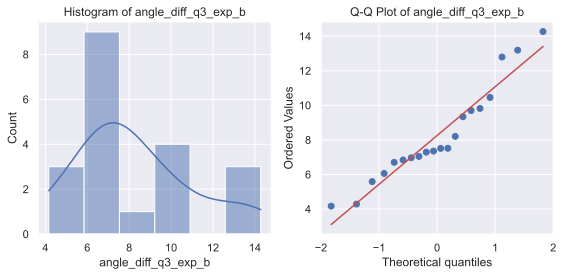

In [120]:
# Shapiro-Wilk normality test
stat, p = shapiro(quartiles_diffs_angle.angle_diff_median_exp_a)
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))
# visual inspection for normality
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.histplot(quartiles_diffs_angle.angle_diff_median_exp_a, kde=True)
plt.title('Histogram of angle_diff_median_exp_a')
plt.subplot(1, 2, 2)
stats.probplot(quartiles_diffs_angle.angle_diff_median_exp_a, dist="norm", plot=plt)
plt.title('Q-Q Plot of angle_diff_median_exp_a')
plt.tight_layout()
plt.show()

# Shapiro-Wilk normality test
stat, p = shapiro(quartiles_diffs_angle.angle_diff_median_exp_b)
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))
# visual inspection for normality
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.histplot(quartiles_diffs_angle.angle_diff_median_exp_b, kde=True)
plt.title('Histogram of angle_diff_median_exp_b')
plt.subplot(1, 2, 2)
stats.probplot(quartiles_diffs_angle.angle_diff_median_exp_b, dist="norm", plot=plt)
plt.title('Q-Q Plot of angle_diff_median_exp_b')
plt.tight_layout()
plt.show()

# Shapiro-Wilk normality test
stat, p = shapiro(quartiles_diffs_angle.angle_diff_q1_exp_a)
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))
# visual inspection for normality
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.histplot(quartiles_diffs_angle.angle_diff_q1_exp_a, kde=True)
plt.title('Histogram of angle_diff_q1_exp_a')
plt.subplot(1, 2, 2)
stats.probplot(quartiles_diffs_angle.angle_diff_q1_exp_a, dist="norm", plot=plt)
plt.title('Q-Q Plot of angle_diff_q1_exp_a')
plt.tight_layout()
plt.show()

# Shapiro-Wilk normality test
stat, p = shapiro(quartiles_diffs_angle.angle_diff_q1_exp_b)
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))
# visual inspection for normality
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.histplot(quartiles_diffs_angle.angle_diff_q1_exp_b, kde=True)
plt.title('Histogram of angle_diff_q1_exp_b')
plt.subplot(1, 2, 2)
stats.probplot(quartiles_diffs_angle.angle_diff_q1_exp_b, dist="norm", plot=plt)
plt.title('Q-Q Plot of angle_diff_q1_exp_b')
plt.tight_layout()
plt.show()

# Shapiro-Wilk normality test
stat, p = shapiro(quartiles_diffs_angle.angle_diff_q3_exp_a)
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))
# visual inspection for normality
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.histplot(quartiles_diffs_angle.angle_diff_q3_exp_a, kde=True)
plt.title('Histogram of angle_diff_q3_exp_a')
plt.subplot(1, 2, 2)
stats.probplot(quartiles_diffs_angle.angle_diff_q3_exp_a, dist="norm", plot=plt)
plt.title('Q-Q Plot of angle_diff_q3_exp_a')
plt.tight_layout()
plt.show()

# Shapiro-Wilk normality test
stat, p = shapiro(quartiles_diffs_angle.angle_diff_q3_exp_b)
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))
# visual inspection for normality
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.histplot(quartiles_diffs_angle.angle_diff_q3_exp_b, kde=True)
plt.title('Histogram of angle_diff_q3_exp_b')
plt.subplot(1, 2, 2)
stats.probplot(quartiles_diffs_angle.angle_diff_q3_exp_b, dist="norm", plot=plt)
plt.title('Q-Q Plot of angle_diff_q3_exp_b')
plt.tight_layout()
plt.show()

Some distributions are not normal, so we proceed with non-parametric tests

In [121]:
# (nonparametric) sign test to see if the angle median is significantly different from zero
stat, p = sign_test(quartiles_diffs_angle.angle_diff_median_exp_a, 0)
print("exp_A", stat, p)
# Wilcoxon signed rank test
hypMedian = 0.0
rank, p = wilcoxon(quartiles_diffs_angle.angle_diff_median_exp_a - hypMedian, zero_method='wilcox', correction=False)
print("exp_A",rank, p)
# (nonparametric) sign test to see if the median is significantly different from zero
stat, p = sign_test(quartiles_diffs_angle.angle_diff_median_exp_b, 0)
print("exp_B", stat, p)
# Wilcoxon signed rank test
hypMedian = 0.0
rank, p = wilcoxon(quartiles_diffs_angle.angle_diff_median_exp_b - hypMedian, zero_method='wilcox', correction=False)
print("exp_B",rank, p)
# mean and median for angle_diff_exp_a
mean_a, median_a = quartiles_diffs_angle['angle_diff_median_exp_a'].mean(), quartiles_diffs_angle['angle_diff_median_exp_a'].median()
# mean and median for angle_diff_exp_b
mean_b, median_b = quartiles_diffs_angle['angle_diff_median_exp_b'].mean(), quartiles_diffs_angle['angle_diff_median_exp_b'].median()
print(f"exp_A angle mean: {mean_a}, median: {median_a}")
print(f"exp_B angle mean: {mean_b}, median: {median_b}")

exp_A -1.0 0.8238029479980469
exp_A 94.0 0.7011814117431641
exp_B 0.0 1.0
exp_B 100.0 0.8694877624511719
exp_A angle mean: -0.306971102734176, median: -0.10466208564999846
exp_B angle mean: -0.1278189308855337, median: 0.06989540211952772


No significant bias in angle, in neither clockwise nor anticlockwise direction

In [130]:
# Wilcoxon signed-rank test for angle_diff_q1_exp_a vs angle_diff_q1_exp_b
stat_neg_a_b, p_value_neg_a_b = wilcoxon(quartiles_diffs_angle['angle_diff_q1_exp_a'], quartiles_diffs_angle['angle_diff_q1_exp_b'])

# Wilcoxon signed-rank test for angle_diff_q3_exp_a vs angle_diff_q3_exp_b
stat_pos_a_b, p_value_pos_a_b = wilcoxon(quartiles_diffs_angle['angle_diff_q3_exp_a'], quartiles_diffs_angle['angle_diff_q3_exp_b'])

print(f"Wilcoxon signed-rank test for angle_diff_q1_exp_a vs angle_diff_q1_exp_b: statistic={stat_neg_a_b}, p-value={p_value_neg_a_b}")
print(f"Wilcoxon signed-rank test for angle_diff_q3_exp_a vs angle_diff_q3_exp_b: statistic={stat_pos_a_b}, p-value={p_value_pos_a_b}")

Wilcoxon signed-rank test for angle_diff_q1_exp_a vs angle_diff_q1_exp_b: statistic=98.0, p-value=0.8123550415039062
Wilcoxon signed-rank test for angle_diff_q3_exp_a vs angle_diff_q3_exp_b: statistic=76.0, p-value=0.2942523956298828


No significant difference in quartiles of angle between the two tasks.

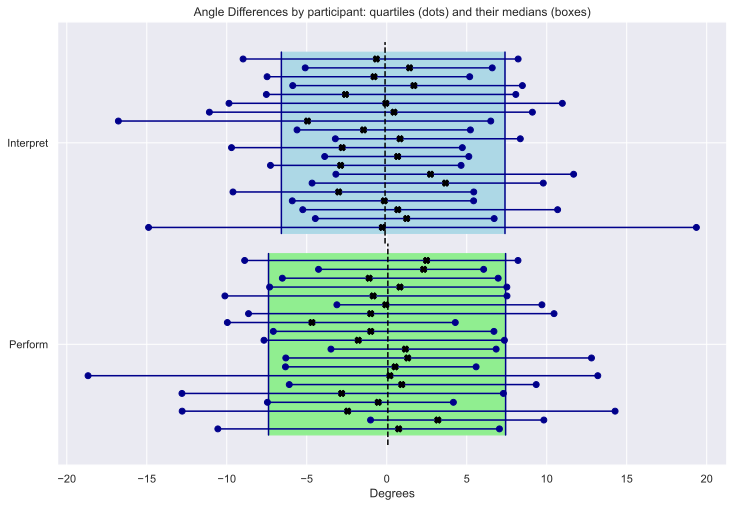

In [128]:
quartiles_diffs_angle = quartiles_diffs_angle.reset_index(drop=True)
# compute the medians of quartiles
median_exp_a = quartiles_diffs_angle['angle_diff_median_exp_a'].median()
median_exp_b = quartiles_diffs_angle['angle_diff_median_exp_b'].median()
median_exp_a_q1 = quartiles_diffs_angle['angle_diff_q1_exp_a'].median()
median_exp_b_q1 = quartiles_diffs_angle['angle_diff_q1_exp_b'].median()
median_exp_a_q3 = quartiles_diffs_angle['angle_diff_q3_exp_a'].median()
median_exp_b_q3 = quartiles_diffs_angle['angle_diff_q3_exp_b'].median()

plt.figure(figsize=(12, 8))
boxplot_data = pd.DataFrame({
    'Experiment': ['Perform', 'Interpret'],
    'Min': [median_exp_b_q1, median_exp_a_q1],
    'Q1': [median_exp_b_q1, median_exp_a_q1],
    'Median': [median_exp_b, median_exp_a],
    'Q3': [median_exp_b_q3, median_exp_a_q3],
    'Max': [median_exp_b_q1, median_exp_a_q1]
})

for i, row in boxplot_data.iterrows():
    plt.plot([row['Q1'], row['Q1']],[i-0.45, i+0.45], color='darkblue')
    plt.plot([row['Q3'], row['Q3']],[i-0.45, i+0.45], color='darkblue')
    if i == 0:
        plt.fill_betweenx([i-0.45, i+0.45], row['Q1'], row['Q3'], color='lightgreen')
    else:
        plt.fill_betweenx([i-0.45, i+0.45], row['Q1'], row['Q3'], color='lightblue')

# add dots for quartiles of individual participants, connected by a line
for i in range(len(quartiles_diffs_angle)):
    plt.plot([quartiles_diffs_angle.loc[i, 'angle_diff_q1_exp_a'], quartiles_diffs_angle.loc[i, 'angle_diff_q3_exp_a']],
             [(0.044 * i)+0.58, (0.044 * i)+0.58], marker='o', color='darkblue', linestyle='-')
    plt.plot([quartiles_diffs_angle.loc[i, 'angle_diff_median_exp_a'], quartiles_diffs_angle.loc[i, 'angle_diff_median_exp_a']],
             [(0.044 * i)+0.58, (0.044 * i)+0.58], marker='X', color='black', linestyle='-')
    plt.plot([quartiles_diffs_angle.loc[i, 'angle_diff_q1_exp_b'], quartiles_diffs_angle.loc[i, 'angle_diff_q3_exp_b']],
             [(0.044 * i)-0.42, (0.044 * i)-0.42], marker='o', color='darkblue', linestyle='-')
    plt.plot([quartiles_diffs_angle.loc[i, 'angle_diff_median_exp_b'], quartiles_diffs_angle.loc[i, 'angle_diff_median_exp_b']],
             [(0.044 * i)-0.42, (0.044 * i)-0.42], marker='X', color='black', linestyle='-')

# median of medians
median_exp_a = quartiles_diffs_angle['angle_diff_median_exp_a'].median()
median_exp_b = quartiles_diffs_angle['angle_diff_median_exp_b'].median()
plt.plot([median_exp_a, median_exp_a], [0.5, 1.5], color='black', linestyle='--')
plt.plot([median_exp_b, median_exp_b], [-0.5, 0.5], color='black', linestyle='--')

plt.yticks(range(len(boxplot_data)), boxplot_data['Experiment'])
plt.xlabel('Degrees')
plt.title('Angle Differences by participant: quartiles (dots) and their medians (boxes)' )
plt.savefig('angle-a-vs-b-user-iqr-n.pdf', format='pdf')
plt.show()


### Measures of precision
as difference between median of Q3 and median of Q1.

In [131]:
print ("medians exp-a q1 and q3", median_exp_a_q1, median_exp_a_q3)
print ("interquartile diff exp-a", median_exp_a_q1 -  median_exp_a_q3)
print ("medians exp-b q1 and q3", median_exp_b_q1, median_exp_b_q3)
print ("interquartile diff exp-b",median_exp_b_q1 -  median_exp_b_q3)

medians exp-a q1 and q3 -6.5856073288166 7.39163780615619
interquartile diff exp-a -13.97724513497279
medians exp-b q1 and q3 -7.389251060339582 7.430951806499458
interquartile diff exp-b -14.82020286683904


# Comparison of speed between Task a and Task b

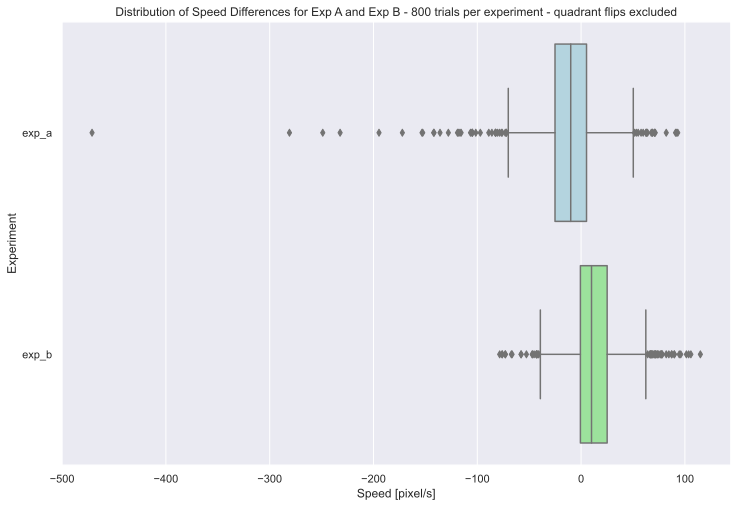

In [136]:
    # create a horizontal boxplot for 'speed_diff', color identifies the task
plt.figure(figsize=(12, 8))
sns.boxplot(x='speed_diff', y='experiment', data=combined_df, orient='h', palette={'exp_a': 'lightblue', 'exp_b': 'lightgreen'})

# set labels and title
plt.xlabel('Speed [pixel/s]')
plt.ylabel('Experiment')
plt.title('Distribution of Speed Differences for Exp A and Exp B - 800 trials per experiment - quadrant flips excluded')
plt.savefig('speed-a-vs-b.pdf', format='pdf')
plt.show()



## Speed difference per participant

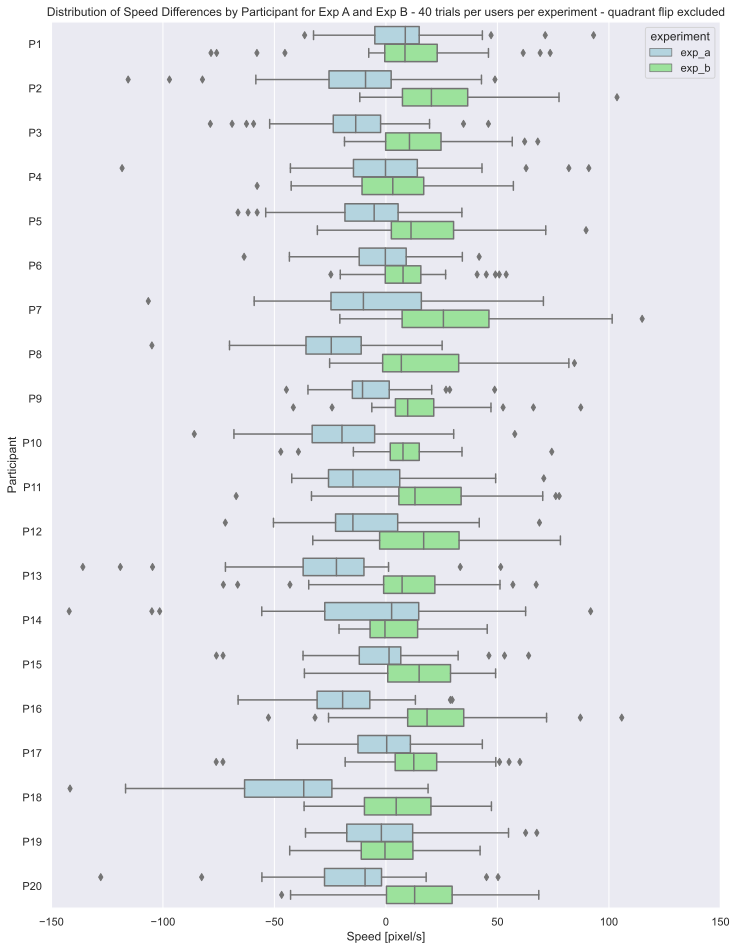

In [138]:
# create a horizontal boxplot for for each participant, alternating between the two tasks
plt.figure(figsize=(12, 16))
sns.boxplot(x='speed_diff', y='nPart', hue='experiment', data=combined_df, orient='h', palette={'exp_a': 'lightblue', 'exp_b': 'lightgreen'})

# set labels and title
plt.xlabel('Speed [pixel/s]')
plt.ylabel('Participant')
plt.title('Distribution of Speed Differences by Participant for Exp A and Exp B - 40 trials per users per experiment - quadrant flip excluded')

# modify the y axis labels to show P1, P2, ..., P20
participant_labels = [f'P{i}' for i in range(1, 21)]
plt.yticks(ticks=range(20), labels=participant_labels)
plt.xlim(-150, 150)
plt.savefig('speed-a-vs-b-users.pdf', format='pdf')
plt.show()

### Median and quartiles of speed per participant

In [140]:
quartiles_diffs_speed = pd.DataFrame()

# compute Q1, median, Q3, of speed per participant per task
for exp in ['exp_a', 'exp_b']:
    mask = combined_df['experiment'] == exp

    first_quartile = combined_df[mask].groupby('nPart')['speed_diff'].quantile(0.25).reset_index()
    first_quartile.columns = ['nPart', f'speed_diff_q1_{exp}']

    median_diff = combined_df[mask].groupby('nPart')['speed_diff'].median().reset_index()
    median_diff.columns = ['nPart', f'speed_diff_median_{exp}']

    third_quartile = combined_df[mask].groupby('nPart')['speed_diff'].quantile(0.75).reset_index()
    third_quartile.columns = ['nPart', f'speed_diff_q3_{exp}']

    if quartiles_diffs_speed.empty:
        quartiles_diffs_speed = first_quartile
    else:
        quartiles_diffs_speed = pd.merge(quartiles_diffs_speed, first_quartile, on='nPart', how='outer')

    quartiles_diffs_speed = pd.merge(quartiles_diffs_speed, median_diff, on='nPart', how='outer')
    quartiles_diffs_speed = pd.merge(quartiles_diffs_speed, third_quartile, on='nPart', how='outer')

display(quartiles_diffs_speed)

,nPart,speed_diff_q1_exp_a,speed_diff_median_exp_a,speed_diff_q3_exp_a,speed_diff_q1_exp_b,speed_diff_median_exp_b,speed_diff_q3_exp_b
0,1,-4.980546,8.683611,14.918003,-0.522056,8.544218,22.997605
1,2,-25.518437,-9.139519,2.350699,7.404835,20.397034,36.675181
2,3,-23.609970,-13.547047,-2.385278,-0.118866,10.558799,24.709125
3,4,-14.557603,-0.187689,14.084934,-10.714094,3.079066,16.950841
4,5,-18.382578,-5.270785,5.463947,2.430319,11.253822,30.341990
5,6,-11.981939,-0.257695,9.087119,-0.297703,7.682530,15.664867
6,7,-24.637205,-10.097762,15.887526,7.264855,25.777616,46.194431
7,8,-35.851729,-24.508643,-11.088614,-1.467644,6.908317,32.635932
8,9,-15.057998,-10.490357,1.485186,4.247193,9.759883,21.446900
9,10,-33.072926,-19.702428,-5.053329,1.941221,7.652974,14.947498


Chcek if quartile and median distributions are normal

Shapiro-Wilk statistics=0.967, p=0.693


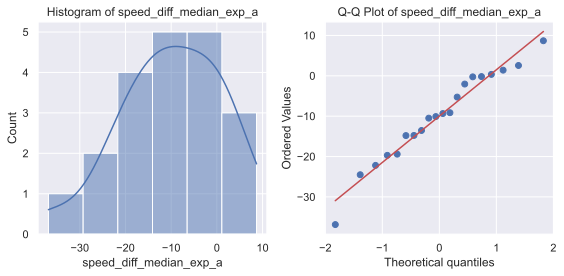

Shapiro-Wilk statistics=0.977, p=0.890


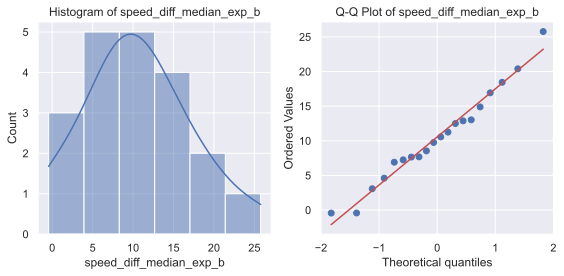

Shapiro-Wilk statistics=0.894, p=0.032


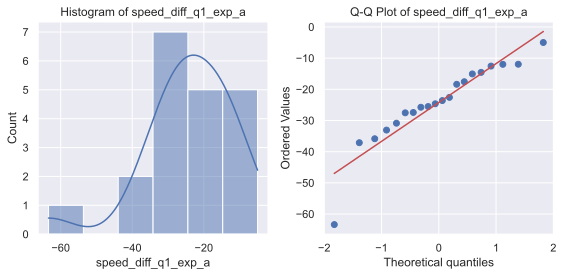

Shapiro-Wilk statistics=0.943, p=0.274


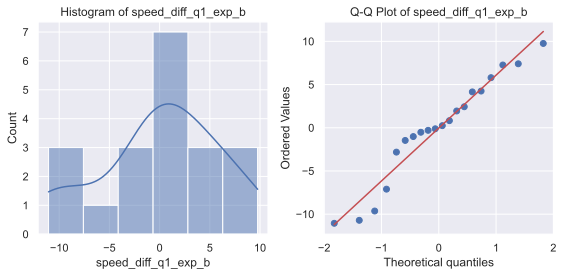

Shapiro-Wilk statistics=0.932, p=0.167


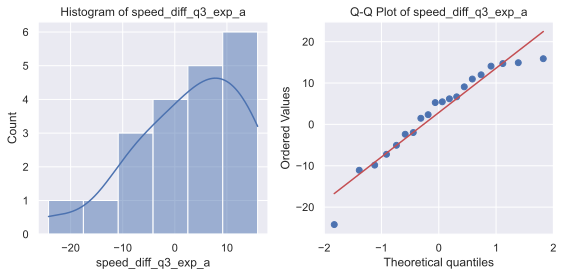

Shapiro-Wilk statistics=0.926, p=0.131


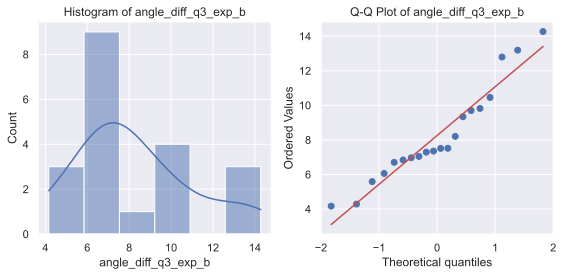

In [141]:
# Shapiro-Wilk normality test
stat, p = shapiro(quartiles_diffs_speed.speed_diff_median_exp_a)
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))
# visual inspection for normality
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.histplot(quartiles_diffs_speed.speed_diff_median_exp_a, kde=True)
plt.title('Histogram of speed_diff_median_exp_a')
plt.subplot(1, 2, 2)
stats.probplot(quartiles_diffs_speed.speed_diff_median_exp_a, dist="norm", plot=plt)
plt.title('Q-Q Plot of speed_diff_median_exp_a')
plt.tight_layout()
plt.show()

# Shapiro-Wilk normality test
stat, p = shapiro(quartiles_diffs_speed.speed_diff_median_exp_b)
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))
# visual inspection for normality
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.histplot(quartiles_diffs_speed.speed_diff_median_exp_b, kde=True)
plt.title('Histogram of speed_diff_median_exp_b')
plt.subplot(1, 2, 2)
stats.probplot(quartiles_diffs_speed.speed_diff_median_exp_b, dist="norm", plot=plt)
plt.title('Q-Q Plot of speed_diff_median_exp_b')
plt.tight_layout()
plt.show()

# Shapiro-Wilk normality test
stat, p = shapiro(quartiles_diffs_speed.speed_diff_q1_exp_a)
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))
# visual inspection for normality
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.histplot(quartiles_diffs_speed.speed_diff_q1_exp_a, kde=True)
plt.title('Histogram of speed_diff_q1_exp_a')
plt.subplot(1, 2, 2)
stats.probplot(quartiles_diffs_speed.speed_diff_q1_exp_a, dist="norm", plot=plt)
plt.title('Q-Q Plot of speed_diff_q1_exp_a')
plt.tight_layout()
plt.show()

# Shapiro-Wilk normality test
stat, p = shapiro(quartiles_diffs_speed.speed_diff_q1_exp_b)
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))
# visual inspection for normality
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.histplot(quartiles_diffs_speed.speed_diff_q1_exp_b, kde=True)
plt.title('Histogram of speed_diff_q1_exp_b')
plt.subplot(1, 2, 2)
stats.probplot(quartiles_diffs_speed.speed_diff_q1_exp_b, dist="norm", plot=plt)
plt.title('Q-Q Plot of speed_diff_q1_exp_b')
plt.tight_layout()
plt.show()

# Shapiro-Wilk normality test
stat, p = shapiro(quartiles_diffs_speed.speed_diff_q3_exp_a)
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))
# visual inspection for normality
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.histplot(quartiles_diffs_speed.speed_diff_q3_exp_a, kde=True)
plt.title('Histogram of speed_diff_q3_exp_a')
plt.subplot(1, 2, 2)
stats.probplot(quartiles_diffs_speed.speed_diff_q3_exp_a, dist="norm", plot=plt)
plt.title('Q-Q Plot of speed_diff_q3_exp_a')
plt.tight_layout()
plt.show()

# Shapiro-Wilk normality test
stat, p = shapiro(quartiles_diffs_angle.angle_diff_q3_exp_b)
print('Shapiro-Wilk statistics=%.3f, p=%.3f' % (stat, p))
# visual inspection for normality
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.histplot(quartiles_diffs_angle.angle_diff_q3_exp_b, kde=True)
plt.title('Histogram of angle_diff_q3_exp_b')
plt.subplot(1, 2, 2)
stats.probplot(quartiles_diffs_angle.angle_diff_q3_exp_b, dist="norm", plot=plt)
plt.title('Q-Q Plot of angle_diff_q3_exp_b')
plt.tight_layout()
plt.show()

At least one distribution can not be considered as normal, so we proceed with non-parametric tests

In [142]:
# (nonparametric) sign test to see if the speed median is significantly different from zero
stat, p = sign_test(quartiles_diffs_speed.speed_diff_median_exp_a, 0)
print("exp_A", stat, p)
# Wilcoxon signed rank test
hypMedian = 0.0
rank, p = wilcoxon(quartiles_diffs_speed.speed_diff_median_exp_a - hypMedian, zero_method='wilcox', correction=False)
print("exp_A",rank, p)
# (nonparametric) sign test to see if the median is significantly different from zero
stat, p = sign_test(quartiles_diffs_speed.speed_diff_median_exp_b, 0)
print("exp_B", stat, p)
# Wilcoxon signed rank test
hypMedian = 0.0
rank, p = wilcoxon(quartiles_diffs_speed.speed_diff_median_exp_b - hypMedian, zero_method='wilcox', correction=False)
print("exp_B",rank, p)
# mean and median for speed_diff_exp_a
mean_a, median_a = quartiles_diffs_speed['speed_diff_median_exp_a'].mean(), quartiles_diffs_speed['speed_diff_median_exp_a'].median()
# mean and median for speed_diff_exp_b
mean_b, median_b = quartiles_diffs_speed['speed_diff_median_exp_b'].mean(), quartiles_diffs_speed['speed_diff_median_exp_b'].median()
print(f"exp_A speed mean: {mean_a}, median: {median_a}")
print(f"exp_B speed mean: {mean_b}, median: {median_b}")

exp_A -6.0 0.01181793212890625
exp_A 21.0 0.000850677490234375
exp_B 8.0 0.0004024505615234375
exp_B 3.0 9.5367431640625e-06
exp_A speed mean: -9.982064541242321, median: -9.72473055752285
exp_B speed mean: 10.564796656756068, median: 10.15934079252972


There is a significant bias in speed, negative for Task A (response is faster than stimulus) and positive for Task B (response is slower than stimulus)

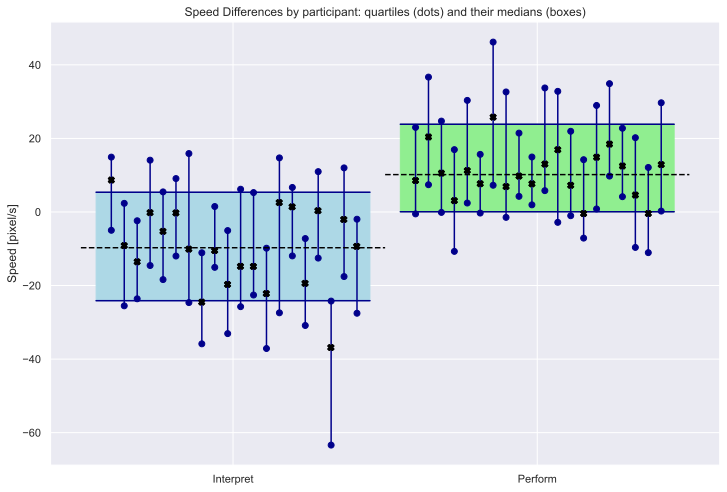

In [157]:
quartiles_diffs_speed = quartiles_diffs_speed.reset_index(drop=True)
# compute the medians of quartiles
median_exp_a = quartiles_diffs_speed['speed_diff_median_exp_a'].median()
median_exp_b = quartiles_diffs_speed['speed_diff_median_exp_b'].median()
median_exp_a_q1 = quartiles_diffs_speed['speed_diff_q1_exp_a'].median()
median_exp_b_q1 = quartiles_diffs_speed['speed_diff_q1_exp_b'].median()
median_exp_a_q3 = quartiles_diffs_speed['speed_diff_q3_exp_a'].median()
median_exp_b_q3 = quartiles_diffs_speed['speed_diff_q3_exp_b'].median()

plt.figure(figsize=(12, 8))
boxplot_data = pd.DataFrame({
    'Experiment': ['Interpret', 'Perform'],
    'Min': [median_exp_a_q1, median_exp_b_q1],
    'Q1': [median_exp_a_q1, median_exp_b_q1],
    'Median': [median_exp_a, median_exp_b],
    'Q3': [median_exp_a_q3, median_exp_b_q3],
    'Max': [median_exp_a_q1, median_exp_b_q1]
})

for i, row in boxplot_data.iterrows():
    plt.plot([i-0.45, i+0.45], [row['Q1'], row['Q1']], color='darkblue')
    plt.plot([i-0.45, i+0.45], [row['Q3'], row['Q3']], color='darkblue')
    if i==0:
      plt.fill_between([i-0.45, i+0.45], row['Q1'], row['Q3'], color='lightblue')
    else:
      plt.fill_between([i-0.45, i+0.45], row['Q1'], row['Q3'], color='lightgreen')
    
# add dots for quartiles of individual participants, connected by a line
for i in range(len(quartiles_diffs_speed)):
    plt.plot([0.0425 * i - 0.4, 0.0425 * i - 0.4], [quartiles_diffs_speed.loc[i, 'speed_diff_q1_exp_a'], quartiles_diffs_speed.loc[i, 'speed_diff_q3_exp_a']],
             marker='o', color='darkblue', linestyle='-')
    plt.plot([0.0424 * i - 0.4, 0.0425 * i - 0.4], [quartiles_diffs_speed.loc[i, 'speed_diff_median_exp_a'], quartiles_diffs_speed.loc[i, 'speed_diff_median_exp_a']],
             marker='X', color='black', linestyle='-')
    plt.plot([0.0425 * i + 0.6, 0.0425 * i + 0.6], [quartiles_diffs_speed.loc[i, 'speed_diff_q1_exp_b'], quartiles_diffs_speed.loc[i, 'speed_diff_q3_exp_b']],
             marker='o', color='darkblue', linestyle='-')
    plt.plot([0.0425 * i + 0.6, 0.0425 * i + 0.6], [quartiles_diffs_speed.loc[i, 'speed_diff_median_exp_b'], quartiles_diffs_speed.loc[i, 'speed_diff_median_exp_b']],
             marker='X', color='black', linestyle='-')

# median of medians
median_exp_a = quartiles_diffs_speed['speed_diff_median_exp_a'].median()
median_exp_b = quartiles_diffs_speed['speed_diff_median_exp_b'].median()
plt.plot([-0.5, 0.5], [median_exp_a, median_exp_a], color='black', linestyle='--')
plt.plot([0.5, 1.5], [median_exp_b, median_exp_b], color='black', linestyle='--')


plt.xticks(range(len(boxplot_data)), boxplot_data['Experiment'])
plt.ylabel('Speed [pixel/s]')
plt.title('Speed Differences by participant: quartiles (dots) and their medians (boxes)' )
plt.savefig('speed-a-vs-b-user-iqr-n.pdf', format='pdf')
plt.show()



### Measures of precision
as difference between median of Q3 and median of Q1.

In [158]:
print ("medians exp-a q1 and q3", median_exp_a_q1, median_exp_a_q3)
print ("interquartile diff exp-a", median_exp_a_q1 -  median_exp_a_q3)
print ("medians exp-b q1 and q3", median_exp_b_q1, median_exp_b_q3)
print ("interquartile diff exp-b",median_exp_b_q1 -  median_exp_b_q3)

medians exp-a q1 and q3 -24.12358730404002 5.369861841419722
interquartile diff exp-a -29.493449145459742
medians exp-b q1 and q3 0.061230606063452875 23.853365088932097
interquartile diff exp-b -23.792134482868644


### TBD
- regression of speed error vs stimulus angle (deviation from diagonal)
- regression of angle error vs stimulus angle (deviation from diagonal)

### TBD
Analysis of relative speed error (percent error)

### TBD

Analysis of questionnaires, as in [Rocchesso et al., 2024](https://www.sciencedirect.com/science/article/pii/S1071581924001411)